# EminemNN: Comparing neural network models for rap lyric generation

NLU project by Phoebe Pinney and Jorgen Jensvold. This project aims to compare two models for generating unique rap lyrics that are recognisably
in the usual style and structure of Eminem. It will compare the results of a simple RNN to a transformer model.

# This notebook contains the RNN model training

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pip installs
!pip3 install pronouncing
!pip3 install textstat
!pip3 install markovify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.3/939.3 kB 16.1 MB/s eta 0:00:00
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6251 sha256=c56124580a2e01b392b663f5030855b5aa0c5b9b4e7055b3087087f593c5ba70
  Stored in directory: /root/.cache/pip/wheels/ee/d4/c2/fb8c0e2009b75358874506ff2ce1ee79370b6ef5cf08922206
Successfully built pronouncing
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.3.0
    Uninstalling importlib-metadata-6.3.0:
      Successfully uninstalled importlib-metadata-6.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.0 MB/s eta 0:00:00
Looking in indexes:

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import random as rand
import numpy as np
import pronouncing
import textstat
import markovify
import math
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input, SimpleRNN, LSTM, GRU, Conv1D, Embedding, Dense, Bidirectional, Dropout
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist, squareform
from keras import Sequential, Model
from keras.callbacks import ReduceLROnPlateau , EarlyStopping
from keras.optimizers import Adam 

## Dataset pre-processing
A dataset of Eminem's entire discography will be used to train the two models within this project. The file "ALL\_eminem.txt" in the dataset contains all 223 of Eminem's songs combined into one text file - this is the data that will be used for training. All lyrics are in English and have been sourced from free lyric hosting websites.

Get lyrics data

In [ ]:
dataFilePath = '/content/drive/MyDrive/ALL_eminem.txt'
with open(dataFilePath, 'r') as file:
  data = (file.read())
eminemBars = data.split('\n') # split lyrics dataset into bars

Get training data

In [ ]:
trainData = eminemBars

# Tokenise
tokeniser = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokeniser.fit_on_texts(trainData)

# Pad the sequences
seq = pad_sequences(tokeniser.texts_to_sequences(trainData), maxlen=30)

# print(tokenizer.word_index.items()) # displays word index

maxFeatures = len(tokeniser.word_index)+1
trainX, trainY = seq[:, :-1], tf.keras.utils.to_categorical(seq[:, -1], num_classes=(maxFeatures))
print(trainX.shape, trainY.shape)

(23629, 29) (23629, 13723)


## Simple RNN model

Here, the simple RNN model architecture is defined.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 512)           7026176   
                                                                 
 dropout (Dropout)           (None, 29, 512)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 150)               99450     
                                                                 
 dense (Dense)               (None, 13723)             2072173   
                                                                 
Total params: 9,197,799
Trainable params: 9,197,799
Non-trainable params: 0
_________________________________________________________________


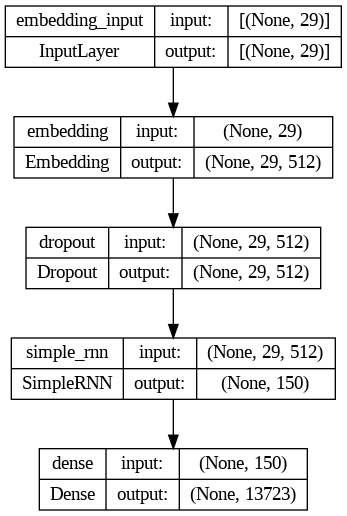

In [ ]:
embedSize = 512

# Create a sequential model
modelRNN = Sequential()

# Add layers to the simple sequential RNN model
modelRNN.add(Embedding(maxFeatures, embedSize, input_length=trainX.shape[1]))
modelRNN.add(Dropout(0.2)) # prevents overfitting
modelRNN.add(SimpleRNN(150))
modelRNN.add(Dense(maxFeatures, activation="softmax"))

# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
modelRNN.compile(optimizer=adam, metrics=["accuracy"], loss="categorical_crossentropy")

# Print the model summary
modelRNN.summary()
tf.keras.utils.plot_model(modelRNN, to_file='modelRNN.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Callback functions to adjust the learning rate and stop training early 
learningRateReduction = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
earlyStop = EarlyStopping(monitor="loss", mode="min", verbose=1, patience=20)

Training the simple RNN.

In [ ]:
RNN = modelRNN.fit(trainX, trainY, epochs=30,callbacks=[learningRateReduction,earlyStop])

Epoch 1/30
739/739 [==============================] - 167s 226ms/step - loss: 3.5002 - accuracy: 0.4049 - lr: 0.0010
Epoch 2/30
739/739 [==============================] - 170s 231ms/step - loss: 2.7387 - accuracy: 0.5271 - lr: 0.0010
Epoch 3/30
739/739 [==============================] - 153s 207ms/step - loss: 2.0998 - accuracy: 0.6463 - lr: 0.0010
Epoch 4/30
739/739 [==============================] - 146s 198ms/step - loss: 1.5973 - accuracy: 0.7372 - lr: 0.0010
Epoch 5/30
739/739 [==============================] - 161s 218ms/step - loss: 1.2266 - accuracy: 0.7965 - lr: 0.0010
Epoch 6/30
739/739 [==============================] - 186s 252ms/step - loss: 0.9660 - accuracy: 0.8417 - lr: 0.0010
Epoch 7/30
739/739 [==============================] - 158s 214ms/step - loss: 0.7793 - accuracy: 0.8698 - lr: 0.0010
Epoch 8/30
739/739 [==============================] - 146s 197ms/step - loss: 0.6443 - accuracy: 0.8937 - lr: 0.0010
Epoch 9/30
739/739 [==============================] - 141s 191ms

Saving the simple RNN model.

In [ ]:
modelRNN.save('EminemNN_simpleRNNmodel.h5') # saves model
!cp EminemNN_simpleRNNmodel.h5 /content/drive/MyDrive/ # saves model to Google Drive

## Lyric generation
The following code is used to generate a set of rap lyrics using one of the two defined models.

In [ ]:
markovModel = markovify.NewlineText(str("\n".join(eminemBars)), well_formed=False, state_size=3) # language model to create seed phrases

In [ ]:
def compareBars(bar, eminemBars):
  """
  Compare the generated bar to each of Eminem's bars
  """
  totalDist = 0
  count = 0

  for eb in eminemBars:
    vectoriser = CountVectorizer()
    barVec = vectoriser.fit_transform([bar, eb])

    # Cosine distance
    barArr = barVec.toarray()
    dist = 1-pdist(barArr, 'cosine')[0]
    if not math.isnan(dist):
      totalDist += dist
      count += 1
  avDist = totalDist/count # lower score means more unique bars
  return avDist

In [ ]:
def rateBar(bar, eminemBars, eminemReadability, eminemRhymeIdx):
  """
  Calculate a rating for the generated bar based on readability, rhyme density and comparison to Eminem's bars
  """
  readability = textstat.automated_readability_index(bar)
  rhymeIdx = getRhymeDensity(bar)
  comparison = compareBars(bar, eminemBars)

  rating = (eminemReadability - readability) + (eminemRhymeIdx - rhymeIdx) + comparison # lower rating is better
  return rating

In [ ]:
def getReadability(bars):
  """
  Returns the average readability score for the given bars
  """
  total = 0
  count = len(bars)

  for bar in bars:
    total += textstat.automated_readability_index(bar)

  averageReadability = total / count
  return averageReadability

In [ ]:
def getRhymeDensity(bars):
  """
  Returns the average rhyme density for the given bars
  """
  totalSyllables = 0
  rhymedSyllables = 0

  for bar in bars:
    for word in bar.split():
      p = pronouncing.phones_for_word(word)
      if len(p) == 0:
        break
      syllables = pronouncing.syllable_count(p[0])
      totalSyllables += syllables
      doesRhyme = False
      for rhyme in pronouncing.rhymes(word):
        if doesRhyme:
          break
        for idx, b in enumerate(bars):
          if idx > 4:
            break
          if rhyme in b:
            rhymedSyllables += syllables
            doesRhyme = True
            break
  rhymeDensity = totalSyllables / rhymedSyllables
  return rhymeDensity

In [ ]:
def generateBar(seedPhrase, model, barLen):
  """
  Generates a bar based on seed phrase
  """
  for i in range(barLen):
    seedTokens = pad_sequences(tokeniser.texts_to_sequences([seedPhrase]), maxlen=29)
    p = model.predict(seedTokens, verbose=0)
    word = np.argmax(p, axis=1)[0]-1
    seedPhrase += " " + str(list(tokeniser.word_index.items())[word][0])
  return seedPhrase

In [ ]:
def generateRap(model, eminemBars, userPrompt, eminemReadability, eminemRhymeIdx, barLen=10, rapLen=10, minThreshold=-0.2, maxThreshold=0.2, attempts=10):
  """
  Generates a rap
  """
  rap = []
  bars = 0
  count = 0
  potentialBars = []

  while len(rap) < rapLen:
    if len(rap)==0:
      seedPhrase = userPrompt
    else:
      seedPhrase = markovModel.make_sentence(tries=100).split(" ") # use Markov model to generate seed phrase
      seedPhrase = " ".join(seedPhrase[:3])
    count += 1
    bar = generateBar(seedPhrase, model, rand.randrange(4, barLen))
    barRating = rateBar(bar, eminemBars, eminemReadability, eminemRhymeIdx) 
    potentialBars.append((barRating, bar))

    if barRating <= maxThreshold and barRating >= minThreshold:
      rap.append(bar)
      bars += 1
      count = 0
      print("Generated Bar:", bars, "\n", bar)

    if count >= attempts:
      lowest = np.Infinity
      bestBar = ""
      for bar in potentialBars:
        if bar[0] < lowest:
          bestBar = bar[1]
          potentialBars = []
      
      rap.append(bestBar)
      bars += 1
      count = 0
      print("Generated Bar:", bars, "\n", bestBar)

  return rap

In [ ]:
loaded_modelRNN = tf.keras.models.load_model('/content/drive/MyDrive/EminemNN_simpleRNNmodel.h5')  # load simple RNN model

In [ ]:
eminemReadability = getReadability(eminemBars) # get readability of actual eminem lyrics
eminemRhymeIdx = getRhymeDensity(eminemBars) # get rhyme density index of actual eminem lyrics

print(eminemReadability, eminemRhymeIdx)

2.9082144822041736 0.3032329559883949


Now, a user prompt can be used to generate a unique rap.

In [ ]:
userPrompt = "I am a legend" # USER PROMPT
rap = generateRap(loaded_modelRNN, eminemBars, userPrompt, eminemReadability, eminemRhymeIdx)

print("\nRap Generated with Simple RNN:")
for line in rap:
  print(line)
print()

readability = getReadability(rap) # get readability of generated rap
rhymeDensity = getRhymeDensity(rap) # get rhyme density index of generated rap
print( "\nAverage readability of rap:\n", readability, "\nAverage rhyme density of rap:\n", rhymeDensity)

Generated Bar: 1 
 I am a legend girl done die for broke in peace spot
Generated Bar: 2 
 Get aware, wake up god disgusting hook you punk who know me
Generated Bar: 3 
 And though me girl girl like that one right again shit
Generated Bar: 4 
 'Cause I'm going back down baby baby baby huh huh huh
Generated Bar: 5 
 I run the fuck down you bitch haha way around defenseless i
Generated Bar: 6 
 Get to the water thing keepin' open pussy knees anger records motherfucker
Generated Bar: 7 
 Don't you want to see you eighty death trouble get
Generated Bar: 8 
 Flavor with no song hand back down there bitch day
Generated Bar: 9 
 We settle it, hurts air suck rhyme first she are
Generated Bar: 10 
 And it ain't because baby baby baby huh

Rap Generated with Simple RNN:
I am a legend girl done die for broke in peace spot
Get aware, wake up god disgusting hook you punk who know me
And though me girl girl like that one right again shit
'Cause I'm going back down baby baby baby huh huh huh
I run the

In [ ]:
with open('simpleRNN_rap.txt', 'w') as f:
  f.write(str(rap))

!cp simpleRNN_rap.txt /content/drive/My Drive/

cp: target 'Drive/' is not a directory
